<a href="https://colab.research.google.com/github/YIFANK/6.7960/blob/main/6_7960_Fall_2025_hw2_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Architecture and inductive bias

**NOTE:** For problem 1 in this notebook, include your answers in the write pdf submission.

We will use the CIFAR-100 in this question, which has **100** classes. Unlike homework 1, we will instead use CNN models to investigate some interesting aspects of training deep models. Moreover, we will use standard PyTorch `nn.Module`s and `optim.Optimizer`s.

<h2>CIFAR-100</h2>

CIFAR-100  is a image classification dataset.
+ Each data sample is an RGB $32\times32$ real image. A raw loaded image $\in \mathbb{R}^{3 \times 32 \times 32}$.
+ Each image is associated with a label $\in \{0,1,2,\dots, 99\}$.


Our goal is to train a neural network classifier that takes such $3\times32\times32$ images and predict a label $\in \{0, 1, 2, \dots, 99\}$.

In [ ]:
# install dependencies

!pip install torch torchvision

You should run on GPU-enabled colab server (should be default for this notebook).

In [ ]:
%matplotlib inline

from typing import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataclasses
from tqdm.auto import tqdm

import torchvision
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
assert torch.cuda.is_available(), "Should use GPU-enabled colab"

device = torch.device('cuda:0')  # we will train with CUDA!

##Dataset
Let's reuse the homework 1 augmented dataset code, but now modified to work on **CIFAR-100**. Code is hidden in the cell below, but make sure to still run it.

100%|██████████| 169M/169M [00:05<00:00, 28.5MB/s]


Training set size: 50000
Validation set size: 10000
CIFAR-100 classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', '

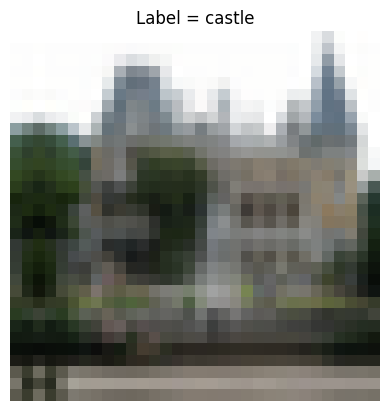

In [ ]:
#@title
%matplotlib inline

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def get_datasets(train_transforms=(), val_transforms=()):
    r"""
    Returns the CIFAR-100 training and validation datasets with corresponding
    transforms.

    `*_transforms` represent optional transformations, e.g., conversion to
    PyTorch tensors, preprocessing, etc.
    """
    train_set = torchvision.datasets.CIFAR100(
        './data', train=True, download=True,
        transform=torchvision.transforms.Compose(train_transforms))
    val_set = torchvision.datasets.CIFAR100(
        './data', train=False, download=True,
        transform=torchvision.transforms.Compose(val_transforms))
    return train_set, val_set


cifar100_mean = torch.as_tensor([0.5071, 0.4865, 0.4409])
cifar100_std = torch.as_tensor([0.2673, 0.2564, 0.2762])

train_transforms = [
    torchvision.transforms.RandomCrop(32, padding=3, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=cifar100_mean, std=cifar100_std),
]

val_transforms = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=cifar100_mean, std=cifar100_std),
]

train_set, val_set = get_datasets(train_transforms, val_transforms)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

class_names = train_set.classes
print(f'CIFAR-100 classes: {class_names}')

def visualize_tensor_data(data: torch.Tensor, label: int):
    # Data is a tensor of shape [C, W, H]  (C is the channel dimension, 3 for RGB)
    # Put channel at last
    data = data.permute(1, 2, 0)
    # Un-normalize
    data = data * cifar100_std + cifar100_mean

    plt.imshow(data)
    plt.axis('off')
    plt.title(f'Label = {class_names[label]}')

data, label = train_set[13]
visualize_tensor_data(data, label)


## Network Definition

**Part 1**: Implement the following function that creates the specified CNN networks. Read through the docstring and make sure that your implementation behaves as required. Afterwards, print the outputs of
+ `make_cnn(100, 'tanh', num_conv_layers=5, num_fc_layers=4)`
+ `make_cnn(3, 'none', num_conv_layers=3, num_fc_layers=2)`

Add both your implementation and outputs to the writeup.

---

Links you may find useful:
+ `none` activation: https://pytorch.org/docs/stable/generated/torch.nn.Identity.html?highlight=identity#torch.nn.Identity
+ Chaining layers: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential
+ Reshaping image-like tensors to vectors: https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten

(You are not required to use these classes)

In [ ]:
def make_mlp(num_inputs: int, num_outputs: int, activation: str, hidden_sizes: int = [128]) -> nn.Module:

    if activation == 'relu':
        act_cls = nn.ReLU
    elif activation == 'tanh':
        act_cls = nn.Tanh
    elif activation == 'none':
        act_cls = nn.Identity
    else:
        raise ValueError(f'Unexpected activation={repr(activation)}')

    net = [nn.Flatten(),
           nn.Linear(num_inputs, hidden_sizes[0]),
           act_cls()]

    for i in range(1, len(hidden_sizes)):
      net.extend([nn.Linear(hidden_sizes[i-1], hidden_sizes[i]),
                  act_cls()])

    net.extend([nn.Linear(hidden_sizes[-1], num_outputs)])

    return nn.Sequential(*net)

In [ ]:
def make_cnn(num_outputs: int, activation: str, num_conv_layers: int = 4, num_fc_layers: int = 2) -> nn.Module:
    r'''
    Returns a PyTorch module representing a CNN network that takes in image-like input with shape [3, 32, 32].

    Args:
        num_outputs (int): size of the final output layer. E.g., if the network is a classifier, this is usually #classes.
        activation (str): activation functions between conv/linear layers. Supported choices are ['relu', 'tanh', 'none'] (always strings).
            For 'none', no activation function is applied, and the previous conv/linear output is directly fed into the next conv/linear.
        num_conv_layers (int): number of conv layers in CNN. This should be >= 3 and <= 5.
            First conv layer should always use 5x5 kernels, mapping 3-channel data to 12-channel data, with **reflect** padding=2 and no striding.
            Subsequent conv layers should always use 3x3 kernels, mapping to 64-channel data, with zeros (default) padding=1 and strides=2.
        num_fc_layers (int): number of fc/linear layers after the convolutional part. This should be >= 2.
            For all but the last fc layer, it should output 128-dimensional vectors.

    Returns:
        (nn.Module) The CNN network of desired tructure.

    If an unexpected input is given, this will raise a ValueError. (You can assume that arguments are of correct types.)
    '''

    # FIXME
    if num_conv_layers < 3 or num_conv_layers > 5:
      raise ValueError(f'Unexpected num_conv_layers={num_conv_layers}')
    if num_fc_layers < 2:
      raise ValueError(f'Unexpected num_fc_layers={num_fc_layers}')

    def get_activation():
      if activation == 'relu':
        return nn.ReLU()
      elif activation == 'tanh':
        return nn.Tanh()
      elif activation == 'none':
        return nn.Identity()
      else:
        raise ValueError
    layers = []
    layers.append(nn.Conv2d(3, 12, kernel_size=5, padding=2, padding_mode='reflect'))
    layers.append(get_activation())
    in_channels = 12
    for i in range(num_conv_layers - 1):
      layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=1, stride=2))
      layers.append(get_activation())
      in_channels = 64
    conv_net = nn.Sequential(*layers)
    #compute flatten size
    with torch.no_grad():
      flatten_size = conv_net(torch.zeros(1, 3, 32, 32)).flatten().shape[0]

    fc_layers = []
    fc_layers.append(nn.Flatten())
    in_channels = flatten_size
    for i in range(num_fc_layers - 1):
      fc_layers.append(nn.Linear(in_channels, 128))
      fc_layers.append(get_activation())
      in_channels = 128
    fc_layers.append(nn.Linear(in_channels, num_outputs))
    fc_net = nn.Sequential(*fc_layers)
    net = nn.Sequential(conv_net, fc_net)
    return net


In [ ]:
print('num_outputs=100, tanh, hidden_sizes=[128, 120]')
print(make_mlp(10, 100, 'tanh', hidden_sizes=[128, 120]))
print()
print('num_outputs=100, tanh, num_conv_layers=5, num_fc_layers=4:')
print(make_cnn(100, 'tanh', num_conv_layers=5, num_fc_layers=4))
print()
print('num_outputs=3, no activation, num_conv_layers=3, num_fc_layers=2:')
print(make_cnn(3, 'none', num_conv_layers=3, num_fc_layers=2))

num_outputs=100, tanh, hidden_sizes=[128, 120]
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=10, out_features=128, bias=True)
  (2): Tanh()
  (3): Linear(in_features=128, out_features=120, bias=True)
  (4): Tanh()
  (5): Linear(in_features=120, out_features=100, bias=True)
)

num_outputs=100, tanh, num_conv_layers=5, num_fc_layers=4:
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (1): Tanh()
    (2): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
  (1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): Tanh()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Tanh()
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): Tanh()
    (7)

## Training loop

**Part 2**: Implement the following training and evaluate functions according to docstring. Complete the `FIXME`s in `train_epoch`, `evaluate`, and `train`. Attach your code to PDF.

---

Links you may find useful:
+ Classification loss: https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy
+ Learning rate adjustment: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

(You are not required to use these classes)

In [ ]:
def train_epoch(epoch: int, model: nn.Module, train_loader: torch.utils.data.DataLoader, optim: torch.optim.Optimizer):
    r"""
    Trains `model` on `train_loader` for cross entropy loss for one epoch.

    Args:
        epoch (int): the current epoch number (i.e., number of epochs done before this one).
        model (nn.Module): our network (created using `make_cnn`).
        train_loader (DataLoader): a DataLoader that yields (batched_images, batched_target_class_indices) when iterated.
        optim (Optimizer): optimizer object that is created with `model` parameters and should be used for updating `model` in this function.

    Returns:
        (List[float]) the losses computed at each iteration as a list of *Python* numbers.

    NOTE:
      + Remember to clear previously computed gradient at beginning of each iteration.
      + Convert loss values to python floats (e.g., via `.item()`) before adding to `loss_values`.
    """
    loss_values: List[float] = []

    for data, target in tqdm(train_loader, desc=f'Training @ epoch {epoch}'):
        # FIXME
        data, target = data.to(device), target.to(device)
        optim.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optim.step()
        loss_values.append(loss.item())

    return loss_values



@dataclasses.dataclass
class EvaluateResult:
    r"""
    A collection containing everything we need to know about the evaluate results.

    See `evaluate` docstring for meanings of the members of this class
    """
    acc: float  # overall accuracy
    correct_predictions: torch.Tensor  # size |dataset|
    confidence: torch.Tensor  # size |dataset|


@torch.no_grad()
def evaluate(model: nn.Module, loader: torch.utils.data.DataLoader) -> EvaluateResult:
    r"""
    Evaluate a classifier `model` on dataset contained in `loader`.

    For each input, the predicted label is taken as one with highest probability in the distribution given by `model`.

    In addition to compute overall accuracies, we also output
        (1) a boolean Tensor with size |dataset|, showing whether each sample is correctly classified.
        (2) a float32 Tensor with size |dataset|, showing the `model`'s assigned probability for its prediction, called *confidence*.

    Args:
        model (nn.Module): our network (created using `make_cnn`).
        loader (DataLoader): a DataLoader that yields (batched_images, batched_target_class_indices) when iterated.

    Returns:
        (EvaluateResult) Containing overall accuracy, whether each sample is correctly classified, and confidence.
            The tensors should be on **CPU**.
    """
    # FIXME
    model.eval()
    all_correct = []
    all_confidence = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)  # shape: [batch, num_classes]

            # predicted class index
            pred = logits.argmax(dim=1)

            # (1) correctness: boolean per-sample
            correct = (pred == y)  # shape: [batch]

            # (2) confidence: probability of the predicted class
            probs = torch.softmax(logits, dim=1)  # shape: [batch, num_classes]
            conf = probs[torch.arange(len(pred)), pred]  # pick prob of chosen class

            all_correct.append(correct.cpu())
            all_confidence.append(conf.cpu())

    # Concatenate into final tensors of shape [|dataset|]
    all_correct = torch.cat(all_correct, dim=0)
    all_confidence = torch.cat(all_confidence, dim=0)

    return EvaluateResult(
        acc=all_correct.float().mean().item(),
        correct_predictions=all_correct,
        confidence=all_confidence,
    )




@dataclasses.dataclass
class TrainResult:
    r"""
    A collection containing everything we need to know about the training results
    """
    num_epochs: int

    # Training loss (saved at each iteration in `train_epoch`)
    train_losses: List[float]

    # The epochs where we perform evaluation
    eval_epochs: List[int]

    # Training accuracies, computed at each epoch in `eval_epochs`
    train_accs: List[float]

    # Validation accuracies, computed at each epoch in `eval_epochs`
    val_accs: List[float]

    # The last validation evaluation full result
    final_val_eval_result: EvaluateResult = None


def train(model: nn.Module, train_set, val_set, *, num_epochs=60, lr=0.003, train_epoch_fn=train_epoch, **kwargs):
    r"""
    Train `model` on `train_set` for `num_epochs` epochs using **Adam** optimizer and `lr` learning rate
    following a decay schedule by a factor of `0.3` at epochs `[5, 50]`.

    Args:
        model (nn.Module): our network (created using `make_cnn`).
        train_set (Dataset): CIFAR-100 training dataset.
        val_set (Dataset): CIFAR-100 validation dataset. Evaluated every *5* epochs and at the end of training.
        num_epochs (int): number of total training epochs.
        lr (float): initial learning rate.
        train_epoch_fn (Callable): function that trains the model for a single epoch. This is `train_epoch`
            usually, but we will use different choices in later questions.

    Returns:
        (TrainResult)
    """
    # Data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True)  # Random order for training ("[S]tochastic" in SGD)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=1024, shuffle=False)

    # Our classifier
    print('Model =', model)

    # Create optimizer and lr scheduler
    # FIXME
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optim,step_size = 10)

    result: TrainResult = TrainResult(num_epochs, train_losses=[], eval_epochs=[], train_accs=[], val_accs=[])
    last_eval_epoch = -float('inf')

    # Iterate through the entire training dataset `num_epochs` times
    for epoch in range(num_epochs):
        if epoch - last_eval_epoch >= 5:
            result.eval_epochs.append(epoch)
            result.train_accs.append(evaluate(model, train_loader).acc)
            result.val_accs.append(evaluate(model, val_loader).acc)
            print(f"Epoch = {epoch:> 2d}    Train acc = {result.train_accs[-1]:.2%}    Val acc = {result.val_accs[-1]:.2%}")
            last_eval_epoch = epoch
        # Train over the entire `train_set` with given `train_epoch_fn` function (i.e., one epoch)
        result.train_losses.extend(train_epoch_fn(epoch, model, train_loader, optim, **kwargs))
        # Evaluate with our `evaluate` function
        print(f"Epoch = {epoch:> 2d}    Train loss = {result.train_losses[-1]:.4f}")

        # Adjust learning rate if needed
        scheduler.step()

    result.eval_epochs.append(num_epochs)
    result.train_accs.append(evaluate(model, train_loader).acc)
    result.final_val_eval_result = evaluate(model, val_loader)
    result.val_accs.append(result.final_val_eval_result.acc)
    print(f"Epoch = {num_epochs:> 2d}    Train acc = {result.train_accs[-1]:.2%}    Val acc = {result.val_accs[-1]:.2%}")

    return result

We provide the following learning curve plotting function (similar to homework 1).

In [ ]:
def learning_curve(result: TrainResult, *, title: str = 'Learning Curve'):
    r"""
    Plot the training loss, training accuracy, and validation accuracy versus
    epochs taken.
    """
    fig, ax_loss = plt.subplots(figsize=(8, 5))
    ax_loss.set_title(title, fontsize=16)
    ax_loss.set_xlabel('Epoch', fontsize=12)

    l_trloss = ax_loss.plot(
        torch.arange(len(result.train_losses)) / len(result.train_losses) * result.num_epochs,
        result.train_losses,
        label='Train loss',
        color='C0',
    )
    ax_loss.set_ylim(0, 4.8)
    ax_loss.set_ylabel('Train loss', color='C0', fontsize=12)
    ax_loss.tick_params(axis='y', labelcolor='C0')

    ax_acc = ax_loss.twinx()
    l_tracc = ax_acc.plot(result.eval_epochs, result.train_accs, label='Train acc', color='C1', linestyle='--')
    if len(result.val_accs):
        l_valacc = ax_acc.plot(result.eval_epochs, result.val_accs, label='Val acc', color='C1')
    else:
        l_valacc = []
    ax_acc.set_ylim(0, 1)
    ax_acc.set_ylabel('Accuracies', color='C1', fontsize=12)
    ax_acc.tick_params(axis='y', labelcolor='C1')

    lines = l_trloss + l_tracc + l_valacc
    ax_loss.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize=13)

Model = Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): Tanh()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): Tanh()
  (5): Linear(in_features=128, out_features=128, bias=True)
  (6): Tanh()
  (7): Linear(in_features=128, out_features=100, bias=True)
)
Epoch =  0    Train acc = 1.24%    Val acc = 1.11%


Training @ epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  0    Train loss = 3.9642
Epoch =  1    Train acc = 10.99%    Val acc = 11.38%


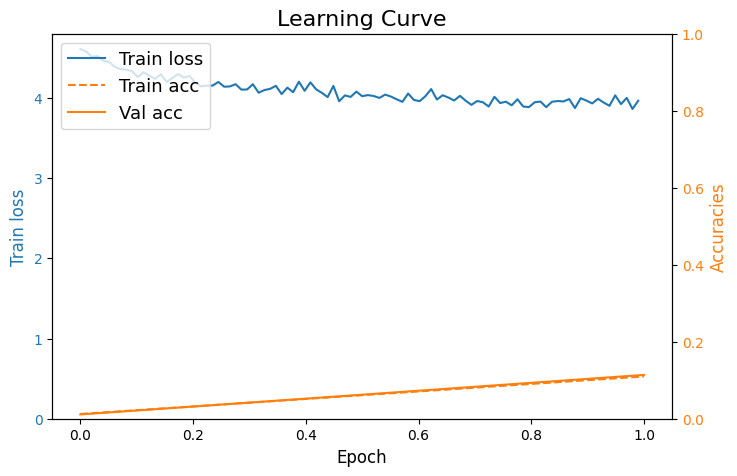

In [ ]:
# Create a MLP 128 width, 3 depth on the GPU, train it, and plot learning curves.
model = make_mlp(3072, 100, 'tanh', hidden_sizes=[128, 128, 128]).to(device)
result = train(model, train_set, val_set, num_epochs=1, lr=0.003)
learning_curve(result)

In [ ]:
# Create a MLP 128 width, 7 depth on the GPU, train it, and plot learning curves.
model = make_mlp(3072, 100, 'tanh', hidden_sizes=[128, 128, 128,128,128,128,128]).to(device)
result = train(model, train_set, val_set, num_epochs=20, lr=0.003)
learning_curve(result)

In [ ]:
# Create a CNN 4 convolutional layers, 3 MLP layers on the GPU, train it, and plot learning curves.
model = make_cnn(100, 'tanh', num_conv_layers=4, num_fc_layers=3).to(device)
result = train(model, train_set, val_set, num_epochs=20, lr=0.003)

Model = Sequential(
  (0): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (1): Tanh()
    (2): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
  (1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): Tanh()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Tanh()
    (5): Linear(in_features=128, out_features=100, bias=True)
  )
)
Epoch =  0    Train acc = 1.30%    Val acc = 1.22%


Training @ epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  0    Train loss = 3.5969


Training @ epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  1    Train loss = 3.4901


Training @ epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Problem 3: Implement a Transformer

In [ ]:
import torch
import torch.nn as nn
from typing import Tuple, Union, Optional, List
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# a utility for calculating running average
class AverageMeter():
    def __init__(self):
        self.num = 0
        self.tot = 0

    def update(self, val: float, sz: float):
        self.num += val*sz
        self.tot += sz

    def calculate(self) -> float:
        return self.num/self.tot

## Part 3.A

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim: the dimension of the input
        # n_hidden: the dimension of the keys, queries, and values

        super().__init__()

        self.W_K = nn.Linear(dim, n_hidden) # W_K weight matrix
        self.W_Q = nn.Linear(dim, n_hidden) # W_Q weight matrix
        self.W_V = nn.Linear(dim, n_hidden) # W_V weight matrix
        self.n_hidden = n_hidden

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing self-attention on x. shape: (Batch x Num_tokens x n_hidden)
        # alpha            the attention weights (after softmax). shape: (B x T x T)
        #

        out, alpha = None, None
        # TODO: Compute self attention on x.
        #       (1) First project x to the query Q, key K, value V.
        #       (2) Then compute the attention weights alpha as:
        #                  alpha = softmax(QK^T/sqrt(n_hidden))
        #           Make sure to take into account attn_mask such that token i does not attend on token
        #           j if attn_mask[b, i, j] == 0. (Hint, in such a case, what value should you set the weight
        #           to before the softmax so that after the softmax the value is 0?)
        #       (3) The output is a linear combination of the values (weighted by the alphas):
        #                  out = alpha V
        #       (4) return the output and the alpha after the softmax

        # ======= Answer START ========
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)
        # (2) Compute attention scores
        scores = torch.matmul(Q, K.transpose(1, 2)) / np.sqrt(self.n_hidden)
        # Apply mask BEFORE softmax
        if attn_mask is not None:
            # attn_mask[b, i, j] == 0 ⇒ disallow
            attn_mask = attn_mask.to(device)
            scores = scores.masked_fill(attn_mask == 0, float('-inf'))

        alpha = torch.softmax(scores, dim=-1)
        attn_output = alpha @ V


        # ======= Answer  END ========

        return attn_output, alpha


## Part 3.B

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, dim: int, n_hidden: int, num_heads: int):
        # dim: the dimension of the input
        # n_hidden: the hidden dimenstion for the attention layer
        # num_heads: the number of attention heads
        super().__init__()

        # TODO: set up your parameters for multi-head attention. You should initialize
        #       num_heads attention heads (see nn.ModuleList) as well as a linear layer
        #       that projects the concatenated outputs of each head into dim
        #       (what size should this linear layer be?)

        # ======= Answer START ========
        self.heads = nn.ModuleList([AttentionHead(dim, n_hidden) for _ in range(num_heads)])
        self.linear = nn.Linear(num_heads * n_hidden, dim)
        # ======= Answer  END ========

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing multi-headed self-attention on x.
        #                  shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_output, attn_alphas = None, None

        # TODO: Compute multi-headed attention. Loop through each of your attention heads
        #       and collect the outputs. Concatenate them together along the hidden dimension,
        #       and then project them back into the output dimension (dim). Return both
        #       the final attention outputs as well as the alphas from each head.

        # ======= Answer START ========
        attn_outputs = []
        attn_alphas = []
        for head in self.heads:
            attn_out, alpha = head(x, attn_mask)
            attn_outputs.append(attn_out)
            attn_alphas.append(alpha)
        attn_output = self.linear(torch.cat(attn_outputs, dim=-1))
        attn_alphas = torch.stack(attn_alphas, dim=1)
        # ======= Answer END ========
        return attn_output, attn_alphas

## Part 3.C

In [ ]:
# these are already implemented for you!

class FFN(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim       the dimension of the input
        # n_hidden  the width of the linear layer

        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, dim),
        )

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        # x         the input. shape: (B x T x dim)

        # Outputs:
        # out       the output of the feed-forward network: (B x T x dim)
        return self.net(x)

class AttentionResidual(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        super().__init__()
        self.attn = MultiHeadedAttention(dim, attn_dim, num_heads)
        self.ffn = FFN(dim, mlp_dim)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_out, alphas = self.attn(x=x, attn_mask=attn_mask)
        x = attn_out + x
        x = self.ffn(x) + x
        return x, alphas

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        # num_layers the number of attention layers.
        super().__init__()

        # TODO: set up the parameters for the transformer!
        #       You should set up num_layers of AttentionResiduals
        #       nn.ModuleList will be helpful here.

        # ======= Answer START ========
        self.layers = nn.ModuleList([AttentionResidual(dim, attn_dim, mlp_dim, num_heads) for _ in range(num_layers)])
        # ======= Answer END ========

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor, return_attn=False)-> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. Pass this to each of the AttentionResidual layers!
        #                  shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      If return_attn is False, return None. Otherwise return the attention weights
        #                  of each of each of the attention heads for each of the layers.
        #                  shape: (B x Num_layers x Num_heads x T x T)

        output, collected_attns = None, None

        # TODO: Implement the transformer forward pass! Pass the input successively through each of the
        # AttentionResidual layers. If return_attn is True, collect the alphas along the way.

        # ======= Answer START ========
        output = x
        collected_attns = []
        for layer in self.layers:
            output, alpha = layer(output, attn_mask)
            if return_attn:
                collected_attns.append(alpha)
        if return_attn:
            collected_attns = torch.stack(collected_attns, dim=1)
        else:
            collected_attns = None
        return output, collected_attns
        # ======= Answer END ========


Test your transformer implementation here

In [ ]:
def perform_transformer_test_cases():
    num_tokens = 100
    batch_size = 10
    dim = 64
    num_layers = 4
    num_heads = 2
    dummy_model = Transformer(dim=dim, attn_dim=32, mlp_dim=dim, num_heads=num_heads, num_layers=num_layers).cuda()

    inp = torch.randn(batch_size, num_tokens, dim).cuda()

    # test case 1 regular forward pass
    print("Test Case 1")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None)
        assert alpha is None
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"

    # test case 2 collect attentions
    print("Test Case 2")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None, return_attn=True)
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"
        assert alpha.shape == (batch_size, num_layers, num_heads, num_tokens, num_tokens), f"wrong alpha shape {alpha.shape}"

    print("Test Case 3")
    # test case 3 with attention mask
    attn_mask = torch.zeros(batch_size, num_tokens, num_tokens).cuda()
    attn_mask[:, torch.arange(num_tokens), torch.arange(num_tokens)] = 1
    attn_mask[:, torch.arange(num_tokens)[1:], torch.arange(num_tokens)[:-1]] = 1
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=attn_mask, return_attn=True)
        print("Attention mask pattern", attn_mask[0])
        print("Alpha pattern", alpha[0, 0, 0])
        assert torch.all(alpha.permute(1, 2, 0, 3, 4)[:, :, attn_mask == 0] == 0).item()

    print("Test Case 4")
    # test case 4 creates a causal mask where each token can only attend to previous tokens and itself
    causal_mask = torch.tril(torch.ones(num_tokens, num_tokens)).unsqueeze(0).repeat(batch_size, 1, 1)  # Shape: (B, T, T)

    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=causal_mask, return_attn=True)
        # Verify the causal mask
        for b in range(batch_size):
            for l in range(num_layers):
                for h in range(num_heads):
                    attn_weights = alpha[b, l, h]  # Shape: (T, T)
                    # Positions where j > i should have zero attention weights
                    # We can create a boolean mask for j > i
                    future_mask = torch.triu(torch.ones(num_tokens, num_tokens), diagonal=1).bool()  # Shape: (T, T)
                    # Extract attention weights for future positions
                    future_attn = attn_weights[future_mask]
                    # Assert that these weights are close to zero
                    assert torch.all(future_attn < 1e-6), f"Causal mask violated in batch {b}, layer {l}, head {h}"

perform_transformer_test_cases()

Test Case 1
Test Case 2
Test Case 3
Attention mask pattern tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]], device='cuda:0')
Alpha pattern tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4276, 0.5724, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6126, 0.3874,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4178, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.6492, 0.3508, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4575, 0.5425]],
       device='cuda:0')
Test Case 4


## Problem 4: Vision Transformer

## Part 4.A

In [ ]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size: int, patch_size: int, nin: int, nout: int):
        # img_size       the width and height of the image. you can assume that
        #                the images will be square
        # patch_size     the width of each square patch. You can assume that
        #                img_size is divisible by patch_size
        # nin            the number of input channels
        # nout           the number of output channels

        super().__init__()
        assert img_size % patch_size == 0

        self.img_size = img_size
        self.num_patches = (img_size // patch_size)**2

        # TODO Set up parameters for the Patch Embedding
        # ======= Answer START ========
        self.proj = nn.Conv2d(nin, nout, kernel_size=patch_size, stride=patch_size)
        # ======= Answer END ========

    def forward(self, x: torch.Tensor):
        # x        the input image. shape: (B, nin, Height, Width)
        #
        # Output
        # out      the patch embeddings for the input. shape: (B, num_patches, nout)


        # TODO: Implement the patch embedding. You want to split up the image into
        # square patches of the given patch size. Then each patch_size x patch_size
        # square should be linearly projected into an embedding of size nout.
        #
        # Hint: Take a look at nn.Conv2d. How can this be used to perform the
        #       patch embedding?
        out = None

        # ======= Answer START ========
        x = self.proj(x)
        out = x.flatten(2).transpose(1, 2)
        # ======= Answer END ========

        return out

## Part 4.B

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, n_channels: int, nout: int, img_size: int, patch_size: int, dim: int, attn_dim: int,
                 mlp_dim: int, num_heads: int, num_layers: int):
        # n_channels       number of input image channels
        # nout             desired output dimension
        # img_size         width of the square image
        # patch_size       width of the square patch
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, nin=n_channels, nout=dim)
        self.pos_E = nn.Embedding((img_size//patch_size)**2, dim) # positional embedding matrix

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim)) # learned class embedding
        self.transformer = Transformer(
            dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, nout)
        )

    def forward(self, img: torch.Tensor, return_attn=False) ->Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # img          the input image. shape: (B, nin, img_size, img_size)
        # return_attn  whether to return the attention alphas
        #
        # Outputs
        # out          the output of the vision transformer. shape: (B, nout)
        # alphas       the attention weights for all heads and layers. None if return_attn is False, otherwise
        #              shape: (B, num_layers, num_heads, num_patches + 1, num_patches + 1)

        # generate embeddings
        embs = self.patch_embed(img) # patch embedding
        B, T, _ = embs.shape
        pos_ids = torch.arange(T).expand(B, -1).to(embs.device)
        embs += self.pos_E(pos_ids) # positional embedding

        cls_token = self.cls_token.expand(len(embs), -1, -1)
        x = torch.cat([cls_token, embs], dim=1)

        x, alphas = self.transformer(x, attn_mask=None, return_attn=return_attn)
        out = self.head(x)[:, 0]
        return out, alphas



## Part 4.C

In [ ]:
# set up the dataset and dataloader

MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2470, 0.2435, 0.2616]
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])
inv_transform = transforms.Compose([
    transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = 1/np.array(STD)),
    transforms.Normalize(
        mean = -np.array(MEAN),
        std = [ 1., 1., 1. ]),
    transforms.ToPILImage(),
])


train_dataset = torchvision.datasets.CIFAR10(train=True, root='data', transform=img_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10(train=False, root='data', transform=img_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=10)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=10)

100%|██████████| 170M/170M [00:05<00:00, 29.4MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# set up the model and optimizer

import torch.optim as optim

model = VisionTransformer(n_channels=3, nout=10, img_size=32, patch_size=4,
                          dim=128, attn_dim=64, mlp_dim=128, num_heads=3, num_layers=6).cuda()

criterion = nn.CrossEntropyLoss()


NUM_EPOCHS = 10
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)



In [ ]:
# evaluate the model
def evaluate_cifar_model(model, criterion, val_loader):
    is_train = model.training
    model.eval()
    with torch.no_grad():
        loss_meter, acc_meter = AverageMeter(), AverageMeter()
        for img, labels in val_loader:
            # move all img, labels to device (cuda)
            img = img.cuda()
            labels = labels.cuda()
            outputs, _ = model(img)
            loss_meter.update(criterion(outputs, labels).item(), len(img))
            acc = (outputs.argmax(-1) == labels).float().mean().item()
            acc_meter.update(acc, len(img))
    model.train(is_train)
    return loss_meter.calculate(), acc_meter.calculate()

In [ ]:
# Time Estimate: less than 5 minutes on T4 GPU
# train the model
import tqdm
for epoch in range(NUM_EPOCHS):  #
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    for img, labels in tqdm.tqdm(train_dataloader):
        img, labels = img.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs, _ = model(img)
        loss = criterion(outputs, labels)
        loss_meter.update(loss.item(), len(img))
        acc = (outputs.argmax(-1) == labels).float().mean().item()
        acc_meter.update(acc, len(img))
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate()}, Acc: {acc_meter.calculate()}")
    if epoch % 10 == 0:
        val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
        print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")

val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")
print('Finished Training')

100%|██████████| 196/196 [00:17<00:00, 11.05it/s]

Train Epoch: 0, Loss: 1.65721997882843, Acc: 0.39534000003814695


Val Epoch: 0, Loss: 1.4418417224884033, Acc: 0.4836


100%|██████████| 196/196 [00:18<00:00, 10.63it/s]


Train Epoch: 1, Loss: 1.3580853159332276, Acc: 0.5112599999809265


100%|██████████| 196/196 [00:18<00:00, 10.75it/s]


Train Epoch: 2, Loss: 1.222199492111206, Acc: 0.5609000000190735


100%|██████████| 196/196 [00:17<00:00, 11.12it/s]


Train Epoch: 3, Loss: 1.1125213229751587, Acc: 0.605320000038147


100%|██████████| 196/196 [00:17<00:00, 10.94it/s]


Train Epoch: 4, Loss: 1.0034805260848998, Acc: 0.6453000000190735


100%|██████████| 196/196 [00:18<00:00, 10.53it/s]


Train Epoch: 5, Loss: 0.8796701052093506, Acc: 0.68814


100%|██████████| 196/196 [00:17<00:00, 11.18it/s]


Train Epoch: 6, Loss: 0.7484134262466431, Acc: 0.737100000038147


100%|██████████| 196/196 [00:17<00:00, 10.97it/s]


Train Epoch: 7, Loss: 0.5978436750602723, Acc: 0.79316


100%|██████████| 196/196 [00:17<00:00, 10.90it/s]


Train Epoch: 8, Loss: 0.4731261102104187, Acc: 0.8439


100%|██████████| 196/196 [00:18<00:00, 10.85it/s]

Train Epoch: 9, Loss: 0.39582678740501404, Acc: 0.8779600000190735


Val Epoch: 9, Loss: 1.342272076034546, Acc: 0.589
Finished Training


## Part 4.D

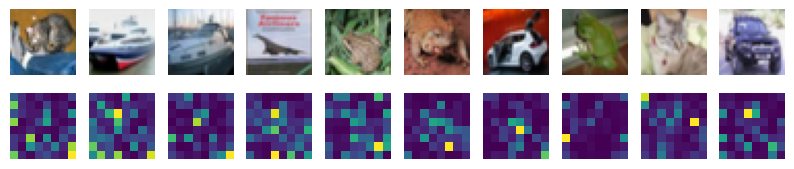

In [ ]:
for val_batch in val_dataloader:
    break

model.eval()
with torch.no_grad():
    img, labels = val_batch
    img = img.cuda()
    outputs, attns = model(img, return_attn=True)

fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    flattened_attns = attns.flatten(1,2)[:, :, 0, 1:].mean(1).reshape(-1, 8, 8).cpu().numpy()
    ax[0, i].imshow(inv_transform(img[i]))
    ax[1, i].imshow(flattened_attns[i])
    ax[0, i].axis(False)
    ax[1, i].axis(False)